# QoS Prediction Model Development - Regression

In [21]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import Ridge


import shap


## Load and Inspect

In [3]:
df = pd.read_csv("data/qws1.txt", delimiter=",", skiprows=42, on_bad_lines="skip")

print(df.head())

       45   83  27.2  50  97.4   89  91      43  58  100  1 DictionaryService  \
0   71.75  100  14.6  88  85.5   78  80   64.42  86   93  1         MyService   
1  117.00  100  23.4  83  88.0  100  87  111.00  59   90  1               aba   
2   70.00  100   5.4  83  79.3  100  75   63.00  91   90  1    AlexaWebSearch   
3  105.20  100  18.2  80  92.2   78  84  104.60  91   90  1       ErrorMailer   
4  224.00  100  24.6  83  80.0  100  87  223.00  88   90  1           getJoke   

  http://www.mindswap.org/2002/services/Dictionary.wsdl  
0          http://mydispatch.com/myservice.asmx?wsdl     
1  http://www.quentinsagerconsulting.com/wsdl/aba...     
2  http://wsearch.amazonaws.com/doc/2007-03-15/We...     
3  http://www.errormail.net/EM/ErrorMailer.asmx?wsdl     
4  http://www.interpressfact.net/webservices/getJ...     


In [4]:

df.columns = [
    "ResponseTime", "Availability", "Throughput", "Successability",
    "Reliability", "Compliance", "BestPractices", "Latency", "Documentation",
    "WsRF", "Class", "ServiceName", "WSDLAddress"
]

print(df.head())


   ResponseTime  Availability  Throughput  Successability  Reliability  \
0         71.75           100        14.6              88         85.5   
1        117.00           100        23.4              83         88.0   
2         70.00           100         5.4              83         79.3   
3        105.20           100        18.2              80         92.2   
4        224.00           100        24.6              83         80.0   

   Compliance  BestPractices  Latency  Documentation  WsRF  Class  \
0          78             80    64.42             86    93      1   
1         100             87   111.00             59    90      1   
2         100             75    63.00             91    90      1   
3          78             84   104.60             91    90      1   
4         100             87   223.00             88    90      1   

      ServiceName                                        WSDLAddress  
0       MyService          http://mydispatch.com/myservice.asmx?wsdl 

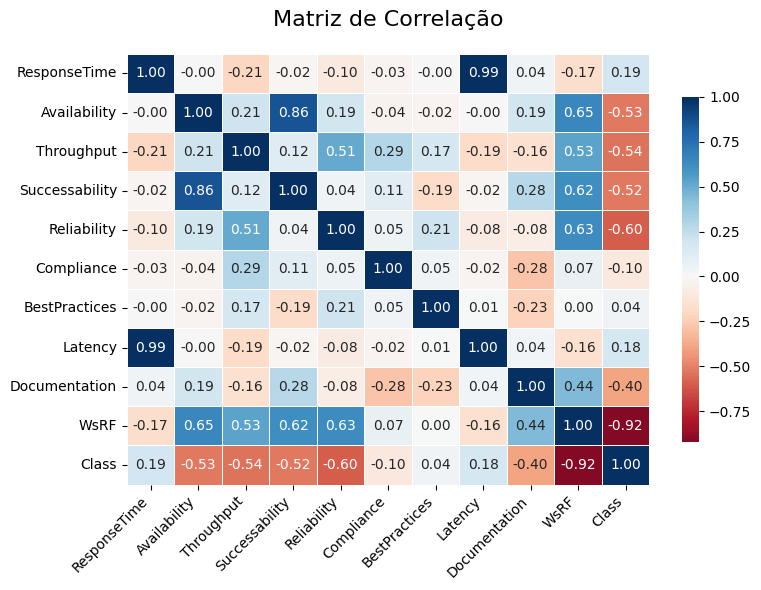

In [14]:
# Calcula a correlação
corr = df.iloc[:, :11].corr()

# Define tamanho da figura
plt.figure(figsize=(8, 6))

# Cria o heatmap com melhorias
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",           
    cmap="RdBu",         
    center=0,           
    linewidths=0.5,     
    cbar_kws={"shrink": 0.8}  
)

# Ajusta título e rótulos
plt.title("Matriz de Correlação", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


Correlação com ResponseTime:
Latency           0.993975
Throughput        0.210343
Class             0.186878
WsRF              0.172231
Reliability       0.095697
Documentation     0.043651
Compliance        0.031962
Successability    0.015138
BestPractices     0.001905
Availability      0.000258
Name: ResponseTime, dtype: float64


C:\Users\bbelissi\AppData\Local\Temp\ipykernel_14880\2227770563.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_sorted.index, y=corr_sorted.values, palette='coolwarm')


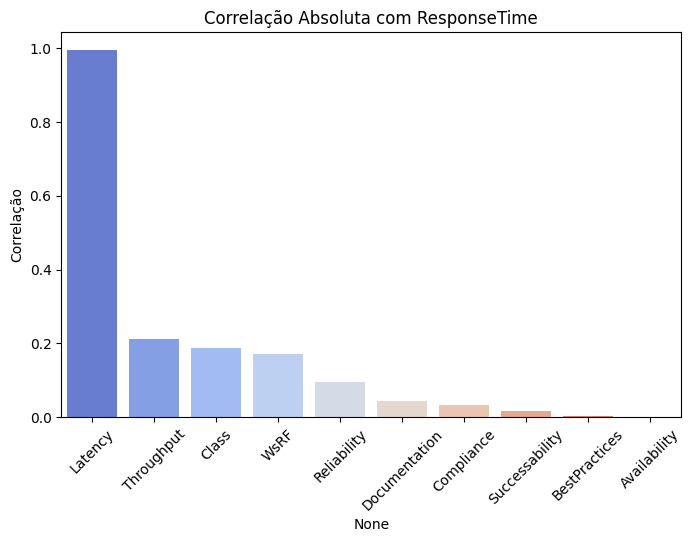

In [6]:
# Seleciona apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcular correlação com ResponseTime
corr = numeric_df.corr()['ResponseTime'].drop('ResponseTime')  # Remove a correlação consigo mesma

# Ordenar por correlação absoluta
corr_sorted = corr.abs().sort_values(ascending=False)

# Exibir correlações
print("Correlação com ResponseTime:")
print(corr_sorted)

# Plotar gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_sorted.index, y=corr_sorted.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Correlação Absoluta com ResponseTime')
plt.ylabel('Correlação')
plt.show()


## Split data

In [7]:

# 1. Definir X e y
X = df.drop(columns=['ResponseTime', 'Latency', 'ServiceName', 'WSDLAddress'])  # Remove target e colunas irrelevantes
y = df['ResponseTime']


In [8]:
# Split (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pré-process

In [9]:

# 3. Log-transform no target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [15]:

# 4. Padronização das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Model

### Linear Regression

In [16]:

# 5. Treinar modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:

# 6. Previsões no espaço log
y_pred_log = model.predict(X_test_scaled)

# 7. Avaliar métricas no espaço log
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

print(f"MAE (log): {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log): {r2_log:.4f}")


MAE (log): 0.4330
RMSE (log): 0.5797
R² (log): 0.7305


In [18]:

# 8. Converter previsões para escala original
y_pred_original = np.expm1(y_pred_log)

# 9. Avaliar métricas na escala original
mae_original = mean_absolute_error(y_test, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2_original = r2_score(y_test, y_pred_original)

print("\nMétricas na escala original:")
print(f"MAE: {mae_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")
print(f"R²: {r2_original:.4f}")



Métricas na escala original:
MAE: 435.0751
RMSE: 1604.8236
R²: 0.1874


### Ridge Model

In [22]:
# 5. Treinar modelo Ridge (com alpha para regularização)
ridge = Ridge(alpha=1.0)  # você pode ajustar alpha (ex.: 0.1, 10)
ridge.fit(X_train_scaled, y_train_log)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [23]:
# 6. Previsões no espaço log
y_pred_log = ridge.predict(X_test_scaled)

In [24]:
# 7. Avaliar métricas no espaço log
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

print(f"Ridge (log) -> MAE: {mae_log:.4f}, RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")

Ridge (log) -> MAE: 0.4382, RMSE: 0.5855, R²: 0.7251


In [25]:
# 8. Converter para escala original
y_pred_original = np.expm1(y_pred_log)
mae_original = mean_absolute_error(y_test, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2_original = r2_score(y_test, y_pred_original)

print("\nMétricas na escala original:")
print(f"MAE: {mae_original:.4f}, RMSE: {rmse_original:.4f}, R²: {r2_original:.4f}")


Métricas na escala original:
MAE: 444.2287, RMSE: 1622.2018, R²: 0.1697
